## CREDIT SCORE CATEGORY CALCULATOR

In [1]:
# Import necessary libraries
import tkinter as tk
from tkinter import ttk
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score

## Preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('credit.csv')

In [3]:
# List of unwanted features
unwanted_features = ['ID', 'Customer_ID', 'Name', 'Age', 'SSN', 'Type_of_Loan', 'Num_Credit_Inquiries',
                     'Occupation','Payment_Behaviour','Payment_of_Min_Amount']

In [4]:
# Drop unwanted features
df = df.drop(unwanted_features, axis=1)

In [5]:
# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['Outstanding_Debt','Interest_Rate','Credit_History_Age','Changed_Credit_Limit','Num_Credit_Card',
                  'Annual_Income','Monthly_Inhand_Salary','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance',
                  'Num_Bank_Accounts','Num_of_Loan','Month','Credit_Utilization_Ratio','Delay_from_due_date',
                  'Num_of_Delayed_Payment']

In [6]:
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [7]:
# Cap outlier values
upper_limits = {}
lower_limits = {}
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper_limits[col] = q3 + 1.5 * iqr
    lower_limits[col] = q1 - 1.5 * iqr

for col in numerical_cols:
    df[col] = np.where(df[col] > upper_limits[col], upper_limits[col], df[col])
    df[col] = np.where(df[col] < lower_limits[col], lower_limits[col], df[col])

In [8]:
# One-hot encoding
categorical_cols = ['Credit_Mix']
df = pd.get_dummies(df, columns=categorical_cols)

In [9]:
# Label Encoding
target_column = 'Credit_Score'
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

## Train Test Split

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_column, axis=1), 
                                                    df[target_column], 
                                                    test_size=0.1, 
                                                    random_state=42)

In [11]:
# Fit the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2,
                                   max_depth=None, bootstrap=False, random_state=42)

In [12]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, random_state=42)

In [13]:
# Evaluate on test set
y_test_pred = rf_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("\nTest Set Accuracy: {:.2f}%".format(accuracy_test * 100))


Test Set Accuracy: 85.19%


## Making Credit Score Category Calculator Application

In [14]:
def preprocess_input(data, scaler):
    numerical_cols = ['Outstanding_Debt', 'Interest_Rate', 'Credit_History_Age', 'Changed_Credit_Limit', 'Num_Credit_Card',
                      'Annual_Income', 'Monthly_Inhand_Salary', 'Total_EMI_per_month', 'Amount_invested_monthly',
                      'Monthly_Balance', 'Num_Bank_Accounts', 'Num_of_Loan', 'Month', 'Credit_Utilization_Ratio',
                      'Delay_from_due_date', 'Num_of_Delayed_Payment']

    # Normalize numerical features
    data[numerical_cols] = scaler.transform(data[numerical_cols])

    return data


## Predict category using model

In [15]:
# Function to predict credit score category
def predict_credit_score():
    # Get input values from GUI
    input_values = {
        'Outstanding_Debt': float(entries["Outstanding Debt"].get()),
        'Interest_Rate': float(entries["Interest Rate"].get()),
        'Credit_History_Age': int(entries["Credit History Age"].get()),
        'Changed_Credit_Limit': float(entries["Changed Credit Limit"].get()),
        'Num_Credit_Card': int(entries["Number of Credit Cards"].get()),
        'Annual_Income': float(entries["Annual Income"].get()),
        'Monthly_Inhand_Salary': float(entries["Monthly Inhand Salary"].get()),
        'Total_EMI_per_month': float(entries["Total EMI per month"].get()),
        'Amount_invested_monthly': float(entries["Amount invested monthly"].get()),
        'Monthly_Balance': float(entries["Monthly Balance"].get()),
        'Num_Bank_Accounts': int(entries["Number of Bank Accounts"].get()),
        'Num_of_Loan': int(entries["Number of Loans"].get()),
        'Month': int(entries["Month"].get()),
        'Credit_Utilization_Ratio': float(entries["Credit Utilization Ratio"].get()),
        'Delay_from_due_date': int(entries["Delay from due date"].get()),
        'Num_of_Delayed_Payment': int(entries["Number of Delayed Payments"].get()),
        'Credit_Mix_Bad': 0,  # Placeholder value, to be updated based on dropdown selection
        'Credit_Mix_Good': 0,  # Placeholder value, to be updated based on dropdown selection
        'Credit_Mix_Standard': 0  # Placeholder value, to be updated based on dropdown selection
    }
    # Credit Mix value wil be Update based on dropdown selection
    selected_credit_mix = credit_mix_dropdown.get()
    if selected_credit_mix == 'Bad':
        input_values['Credit_Mix_Bad'] = 1
    elif selected_credit_mix == 'Good':
        input_values['Credit_Mix_Good'] = 1
    elif selected_credit_mix == 'Standard':
        input_values['Credit_Mix_Standard'] = 1

    # Create DataFrame from input values
    input_df = pd.DataFrame([input_values])

    # Reorder columns to match the order during training
    input_df = input_df[X_train.columns]
    
    # Preprocess input data
    input_df = preprocess_input(input_df, scaler)
    # Make prediction
    prediction = rf_model.predict(input_df)

    # Decode prediction
    predicted_category = label_encoder.inverse_transform(prediction)[0]

    # Update result label
    result_label.config(text="Predicted Credit Score Category: " + predicted_category)

## GUI window

In [22]:
# Create GUI window
window = tk.Tk()
window.title("Credit Score Category Calculator")

# Create input fields
input_fields = ["Outstanding Debt", "Interest Rate", "Credit History Age", "Changed Credit Limit", "Number of Credit Cards",
                "Annual Income", "Monthly Inhand Salary", "Total EMI per month", "Amount invested monthly", "Monthly Balance",
                "Number of Bank Accounts", "Number of Loans", "Month", "Credit Utilization Ratio", "Delay from due date",
                "Number of Delayed Payments"]

entries = {}
for i, field in enumerate(input_fields):
    tk.Label(window, text=field + ":").grid(row=i, column=0)
    entries[field] = tk.Entry(window)
    entries[field].grid(row=i, column=1)

# Credit Mix dropdown
tk.Label(window, text="Credit Mix:").grid(row=len(input_fields), column=0)
credit_mix_variable = tk.StringVar(window)
credit_mix_dropdown = ttk.Combobox(window, textvariable=credit_mix_variable, values=('Bad', 'Good', 'Standard'))
credit_mix_dropdown.grid(row=len(input_fields), column=1)

# Create predict button
predict_button = tk.Button(window, text="Predict", command=predict_credit_score)
predict_button.grid(row=len(input_fields) + 1, columnspan=2)

# Create result label
result_label = tk.Label(window, text="")
result_label.grid(row=len(input_fields) + 2, columnspan=2)

## Run window

In [29]:
# Run the GUI
window.mainloop()

## displaying a screenshot of the application preview

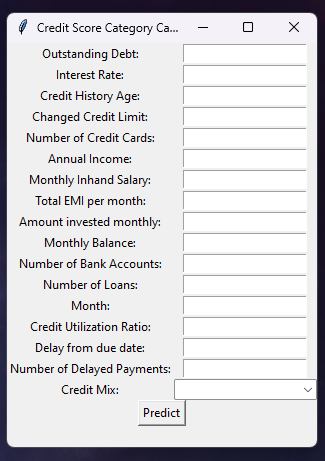

In [19]:
from IPython.display import display, Image

# Path to your PNG image
image_path = "Screenshot 2024-04-18 215607.png"

# Display the image
display(Image(filename=image_path))


## displaying a screenshot of the application output

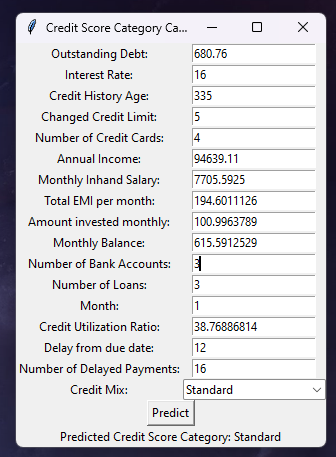

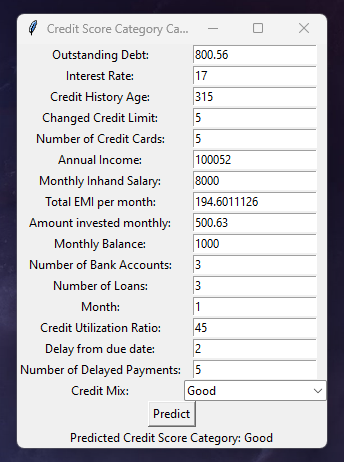

In [30]:
from IPython.display import display, Image

# Path to your PNG images
image_paths = ["Screenshot 2024-04-18 220621.png", "Screenshot 2024-04-18 220954.png"]

# Display each image
for path in image_paths:
    display(Image(filename=path))
